<a href="https://colab.research.google.com/github/sakibchowdhury131/railcop/blob/main/__DFT%2BBONSAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/microsoft/EdgeML.git

fatal: destination path 'EdgeML' already exists and is not an empty directory.


In [3]:
%cd /content/EdgeML/tf/

/content/EdgeML/tf


In [4]:
!pip install -r requirements-cpu.txt
!pip install -e .

Obtaining file:///content/EdgeML/tf
  Attempting uninstall: edgeml-tf
    Found existing installation: edgeml-tf 0.3.0
    Can't uninstall 'edgeml-tf'. No files were found to uninstall.
  Running setup.py develop for edgeml-tf


### Defining Bonsai Model

In [5]:
%cd /content/EdgeML/examples/tf/Bonsai
import helpermethods

/content/EdgeML/examples/tf/Bonsai


In [6]:
import tensorflow as tf
import numpy as np
import sys
import os

#Provide the GPU number to be used
os.environ['CUDA_VISIBLE_DEVICES'] =''

#Bonsai imports
from edgeml_tf.trainer.bonsaiTrainer import BonsaiTrainer
from edgeml_tf.graph.bonsai import Bonsai

# Fixing seeds for reproducibility
tf.set_random_seed(42)
np.random.seed(42)

In [8]:
import matplotlib.pyplot as plt
import math
import pandas as pd
print(pd.__version__)

0.23.4


In [9]:
label0 = pd.read_csv('/content/drive/MyDrive/RailCop/New Files/Sakib/data/label0/Copy of train_1.csv')
label1 = pd.read_csv('/content/drive/MyDrive/RailCop/New Files/Sakib/data/label1/Copy of train_1.csv')
print(label1)

      Sensor1           ...             Sensor1+Sensor2+Sensor3
0           2           ...                                  12
1           4           ...                                  13
2           4           ...                                  15
3           4           ...                                  16
4           2           ...                                  12
5           5           ...                                  13
6           3           ...                                  11
7           4           ...                                  15
8           3           ...                                  14
9           4           ...                                  13
10          3           ...                                  13
11          3           ...                                  13
12          4           ...                                  12
13          4           ...                                  14
14          4           ...             

In [10]:
__fullVector0 = label0['Sensor1+Sensor2+Sensor3'].as_matrix()
__fullVector1 = label1['Sensor1+Sensor2+Sensor3'].as_matrix()


print(__fullVector0.shape)
print(__fullVector1.shape)


(23050,)
(5389,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [11]:
__frameSize = 50

## label 0 framing

__numFrames0 = int(__fullVector0.shape[0] / __frameSize)
__frames0 = np.zeros((__numFrames0,__frameSize))
for i in range (0, __numFrames0):
  for j in range (0, __frameSize):
    __frames0[i][j] = __fullVector0[i*__frameSize+j]

In [12]:
## label 1 framing

__numFrames1 = int(__fullVector1.shape[0] / __frameSize)
__frames1 = np.zeros((__numFrames1,__frameSize))
for i in range (0, __numFrames1):
  for j in range (0, __frameSize):
    __frames1[i][j] = __fullVector1[i*__frameSize+j]

In [13]:
__frames0.shape

(461, 50)

In [14]:
__frames1.shape

(107, 50)

In [15]:
__maxFrames = __frames1.shape[0]
__label0 = __frames0[0:__maxFrames, :]
__label1 = __frames1[0:__maxFrames, :]

In [16]:
Y0 = np.zeros(__label0.shape[0])
Y1 = np.ones(__label1.shape[0])
print(Y0.shape)
print(Y1.shape)

(107,)
(107,)


In [17]:
## Applying DFT
## finding Fourier Co-efficients Xn

def get_xn(samples,n):
    L  = len(samples)
    ks = np.arange(0,L,1)
    xn = np.sum(samples*np.exp((1j*2*np.pi*ks*n)/L))/L
    return(xn)

In [18]:
## Compute Fourier coefficients only up to the Nyquest Limit Xn, n=1,...,L/2 and 
## multiply the absolute value of the Fourier coefficients by 2, to account for 
## the symetry of the Fourier coefficients above the Nyquest Limit.


def get_xns(samples):
    mag = []
    L = len(samples)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(get_xn(samples,n))*2)
    return(mag)
mag = get_xns(__frames0[4])

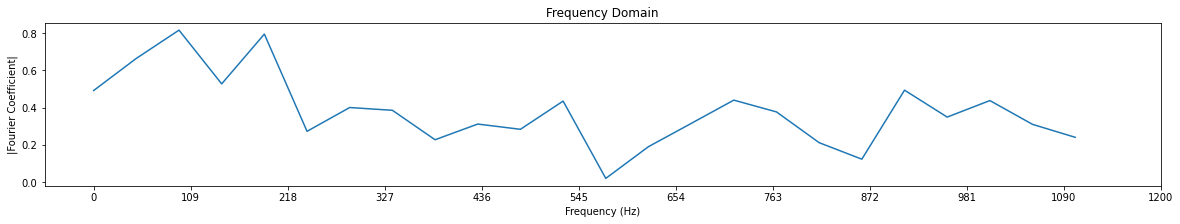

In [19]:
## Fourier Plot 

def get_Hz_scale_vec(ks,sample_rate,Npoints):
    freq_Hz = ks*sample_rate/Npoints
    freq_Hz  = [int(i) for i in freq_Hz ] 
    return(freq_Hz )
Nxlim = 12
sample_rate = int(9600/4)             
ks   = np.linspace(0,len(mag),Nxlim)
ksHz = get_Hz_scale_vec(ks,sample_rate,len(__frames1[0]))

plt.figure(figsize=(20,3))
plt.plot(mag[1:])
plt.xticks(ks,ksHz)
plt.title("Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Fourier Coefficient|")
plt.show()

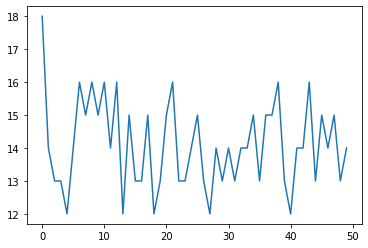

In [20]:
plt.plot (__label0[3])

In [21]:
## Fourier coefficients of label0 
__fourier0 = np.zeros((__maxFrames,len(mag)))
for i in range(0, __maxFrames):
  __fourier0[i] = np.array(get_xns(__label0[i]))



## Fourier coefficients of label1 
__fourier1 = np.zeros((__maxFrames,len(mag)))
for i in range(0, __maxFrames):
  __fourier1[i] = np.array(get_xns(__label1[i]))

In [22]:
X = np.asarray(np.concatenate((__fourier0[:, 1:], __fourier1[:, 1:]), axis = 0), dtype=np.float32)
Y = np.asarray(np.concatenate((Y0, Y1), axis = 0), dtype = np.float32)
print(X.shape)
print(Y.shape)

(214, 24)
(214,)


In [23]:
from sklearn.utils import shuffle
X, Y = shuffle(X,Y)

In [24]:
X.shape

(214, 24)

In [25]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33, random_state=42)

In [35]:
sigma = 1.0 #Sigmoid parameter for tanh
depth = 3 #Depth of Bonsai Tree
projectionDimension = 28 #Lower Dimensional space for Bonsai to work on

#Regularizers for Bonsai Parameters
regZ = 0.0001
regW = 0.001
regV = 0.001
regT = 0.001

totalEpochs = 600

learningRate = 0.01

outFile = None

#Sparsity for Bonsai Parameters. x => 100*x % are non-zeros
sparZ = 0.2
sparW = 0.3
sparV = 0.3
sparT = 0.62

batchSize = np.maximum(100, int(np.ceil(np.sqrt(Ytrain.shape[0]))))

useMCHLoss = True #only for Multiclass cases True: Multiclass-Hing Loss, False: Cross Entropy. 

#Bonsai uses one classier for Binary, thus this condition

numClasses = 1

In [27]:
Xtrain.shape


(143, 24)

In [28]:
__X = tf.placeholder("float32", [None, Xtrain.shape[1]])
__Y = tf.placeholder("float32", [None, numClasses])

In [29]:
bonsaiObj = Bonsai(numClasses, Xtrain.shape[1], projectionDimension, depth, sigma)

In [30]:
bonsaiTrainer = BonsaiTrainer(bonsaiObj, regW, regT, regV, regZ, sparW, sparT, sparV, sparZ,
                              learningRate, __X, __Y, useMCHLoss, outFile)

In [31]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [32]:
Ytrain.shape

(143,)

In [33]:
Ytrain = np.expand_dims(Ytrain,1)
Ytest = np.expand_dims(Ytest,1)

In [36]:
bonsaiTrainer.train(batchSize, totalEpochs, sess,
                    Xtrain, Xtest, Ytrain, Ytest, '/content', '/content')


Epoch Number: 0

******************** Dense Training Phase Started ********************


Classification Train Loss: 0.8331303596496582
Training accuracy (Classification): 0.7099999785423279
Test accuracy 0.633803
MarginLoss + RegLoss: 0.8257654 + 0.20440209 = 1.0301675


Epoch Number: 1

Classification Train Loss: 0.8279882073402405
Training accuracy (Classification): 0.7300000190734863
Test accuracy 0.633803
MarginLoss + RegLoss: 0.8279642 + 0.20323539 = 1.0311996


Epoch Number: 2

Classification Train Loss: 0.8232915997505188
Training accuracy (Classification): 0.7400000095367432
Test accuracy 0.633803
MarginLoss + RegLoss: 0.82959414 + 0.20201086 = 1.031605


Epoch Number: 3

Classification Train Loss: 0.8188823461532593
Training accuracy (Classification): 0.7400000095367432
Test accuracy 0.647887
MarginLoss + RegLoss: 0.82873964 + 0.20072746 = 1.0294671


Epoch Number: 4

Classification Train Loss: 0.8141602873802185
Training accuracy (Classification): 0.7400000095367432
Test ac